# **Pembangunan Sistem Rekomendasi untuk Memprediksi Preferensi Pembelian Pelanggan menggunakan Colaborative Filtering pada Dataset Walmart Customer Purchase Behavior**

## **Objective:**   
Tujuan dari kode ini adalah untuk membangun sistem rekomendasi pembelian pelanggan Walmart menggunakan pendekatan Collaborative Filtering, khususnya User-Based Collaborative Filtering. Sistem ini mengandalkan profil pelanggan (seperti usia dan negara), metode pembayaran, preferensi historis, dan kategori produk yang dibeli untuk mencocokkan pelanggan dengan pelanggan lain yang memiliki pola belanja serupa. Dengan pendekatan ini, sistem dapat memberikan rekomendasi produk yang dipersonalisasi berdasarkan perilaku pelanggan lain yang mirip. Berbeda dengan Content-Based Filtering, pendekatan ini memanfaatkan hubungan antar pengguna dan cocok diterapkan pada data transaksional seperti dataset Walmart Customer Purchase Behavior, meskipun tanpa memerlukan rating eksplisit.

## **Sumber Dataset**
https://www.kaggle.com/datasets/logiccraftbyhimanshi/walmart-customer-purchase-behavior-dataset


# **Import Library**

In [1]:
!pip install pandas numpy scikit-learn matplotlib seaborn


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors



# **Load data**

In [3]:
from google.colab import files
files.upload()

Saving kaggle (17).json to kaggle (17).json


{'kaggle (17).json': b'{"username":"tiprihartati","key":"015f66d58bade12bbea4dc49bd786dfe"}'}

In [4]:
!mv "kaggle (17).json" kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d smayanj/e-commerce-transactions-dataset

!unzip -qq e-commerce-transactions-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/smayanj/e-commerce-transactions-dataset
License(s): CC0-1.0
  0% 0.00/749k [00:00<?, ?B/s]
100% 749k/749k [00:00<00:00, 836MB/s]


In [5]:
data = pd.read_csv('/content/e-commerce-transactions-dataset.zip')
data.head()

,Transaction_ID,User_Name,Age,Country,Product_Category,Purchase_Amount,Payment_Method,Transaction_Date
0,1,Ava Hall,63,Mexico,Clothing,780.69,Debit Card,2023-04-14
1,2,Sophia Hall,59,India,Beauty,738.56,PayPal,2023-07-30
2,3,Elijah Thompson,26,France,Books,178.34,Credit Card,2023-09-17
3,4,Elijah White,43,Mexico,Sports,401.09,UPI,2023-06-21
4,5,Ava Harris,48,Germany,Beauty,594.83,Net Banking,2024-10-29


# **Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset. EDA bertujuan untuk:

- memahami struktur data
- menangani missing value dan duplikat
- Visualisasi distribusi data
- Analisis perilaku pembelian
- segmentasi Pelanggan

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

### Memahami struktur data
mengetahui jumlah baris, kolom, tipe data dan ringkasan statistik pada data

In [6]:
data

,Transaction_ID,User_Name,Age,Country,Product_Category,Purchase_Amount,Payment_Method,Transaction_Date
0,1,Ava Hall,63,Mexico,Clothing,780.69,Debit Card,2023-04-14
1,2,Sophia Hall,59,India,Beauty,738.56,PayPal,2023-07-30
2,3,Elijah Thompson,26,France,Books,178.34,Credit Card,2023-09-17
3,4,Elijah White,43,Mexico,Sports,401.09,UPI,2023-06-21
4,5,Ava Harris,48,Germany,Beauty,594.83,Net Banking,2024-10-29
...,...,...,...,...,...,...,...,...
49995,49996,Isabella Rodriguez,53,India,Electronics,140.09,UPI,2024-08-07
49996,49997,Emma Hall,30,France,Home & Kitchen,815.31,Cash on Delivery,2025-02-07
49997,49998,Isabella Allen,50,Australia,Beauty,535.77,UPI,2023-08-11
49998,49999,Olivia Clark,48,Australia,Grocery,370.99,Cash on Delivery,2025-01-02


In [7]:
len(data)

50000

In [8]:
data.info()
data.dtypes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transaction_ID    50000 non-null  int64  
 1   User_Name         50000 non-null  object 
 2   Age               50000 non-null  int64  
 3   Country           50000 non-null  object 
 4   Product_Category  50000 non-null  object 
 5   Purchase_Amount   50000 non-null  float64
 6   Payment_Method    50000 non-null  object 
 7   Transaction_Date  50000 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 3.1+ MB


,0
Transaction_ID,int64
User_Name,object
Age,int64
Country,object
Product_Category,object
Purchase_Amount,float64
Payment_Method,object
Transaction_Date,object


## Menangani missing value dan duplikat
mengidentifikasi kolom yang memiliki nilai null dan duplikat data. hal ini untuk melihat apakah data yang di gunakan sudah bersih atau belum

In [9]:
data.isnull().sum()



,0
Transaction_ID,0
User_Name,0
Age,0
Country,0
Product_Category,0
Purchase_Amount,0
Payment_Method,0
Transaction_Date,0


In [10]:
data.duplicated().sum()

np.int64(0)

## Visualisasi Distribusi Data
memberikan gambaran umum/ visualisasi dari data yang tersedia

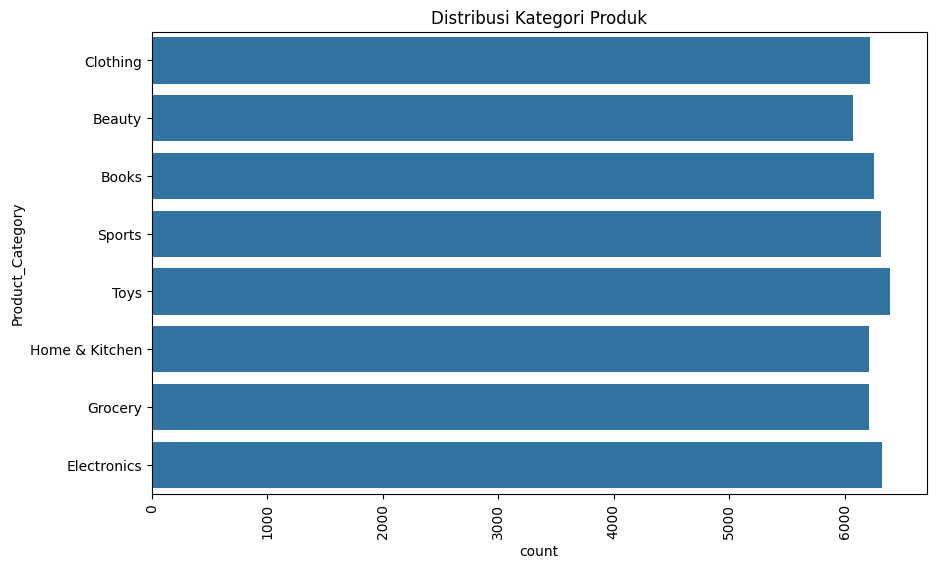

In [11]:
plt.figure(figsize=(10,6))
sns.countplot(data['Product_Category'])
plt.title('Distribusi Kategori Produk')
plt.xticks(rotation=90)
plt.show()

berdasarkan grafik distribusi produk, produk cloting, toys, dan elektronik memiliki jumlah distribusi paling banyak dalam data ini.

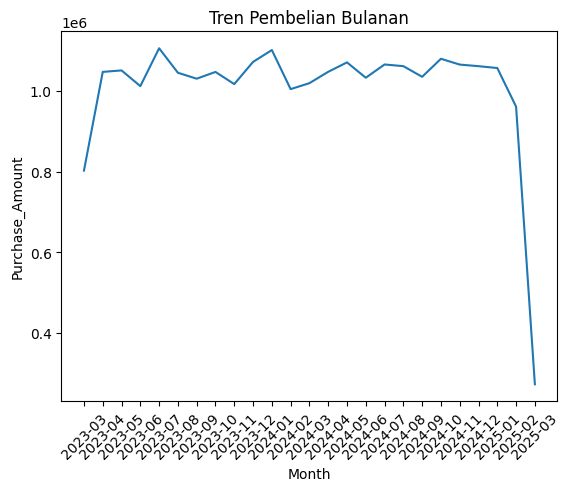

In [12]:
# Ubah kolom ke format datetime
data['Transaction_Date'] = pd.to_datetime(data['Transaction_Date'], errors='coerce')

# Tambahkan kolom bulan dan tahun
data['Month'] = data['Transaction_Date'].dt.to_period('M')

# Tren pembelian bulanan
monthly_trend = data.groupby('Month')['Purchase_Amount'].sum().reset_index()
monthly_trend['Month'] = monthly_trend['Month'].astype(str)

sns.lineplot(data=monthly_trend, x='Month', y='Purchase_Amount')
plt.xticks(rotation=45)
plt.title('Tren Pembelian Bulanan')
plt.show()


grafik ini memberikan gambaran bagaimana tren pembelian produk tiap bualan.

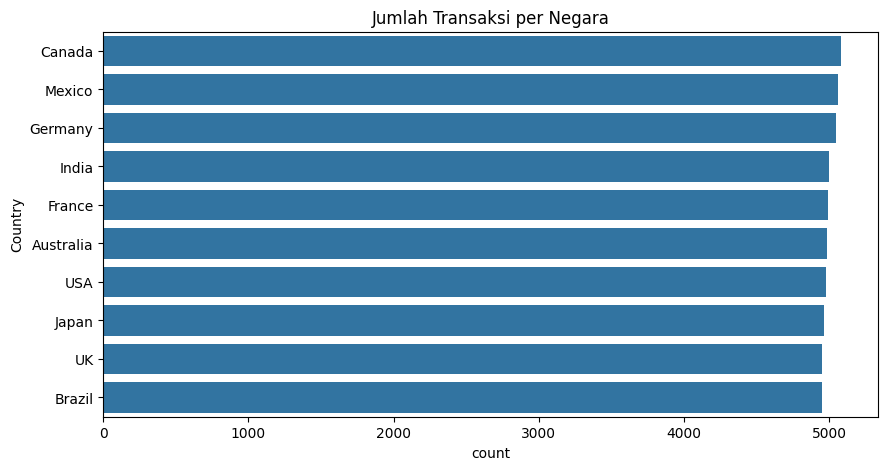

In [13]:
# Jumlah transaksi per negara
plt.figure(figsize=(10,5))
sns.countplot(y='Country', data=data, order=data['Country'].value_counts().index)
plt.title('Jumlah Transaksi per Negara')
plt.show()


plot distribusi transaksi pernegara menunjukan bahwa paling banyak transaksi terjadi di negara canada, kemudian mexico dan Germany

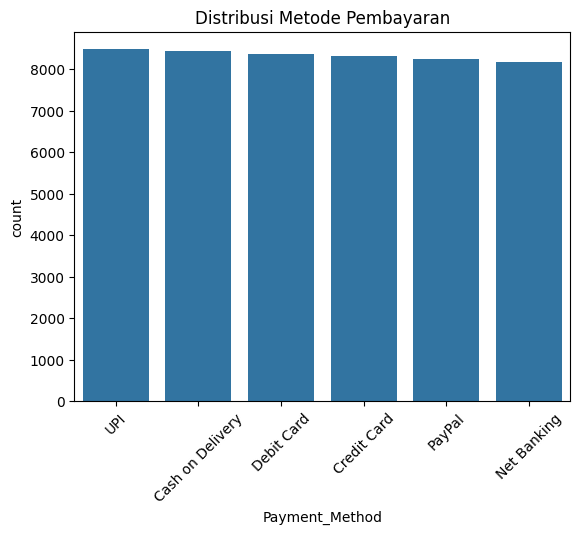

In [14]:
# Pie chart atau countplot metode pembayaran
sns.countplot(x='Payment_Method', data=data, order=data['Payment_Method'].value_counts().index)
plt.title('Distribusi Metode Pembayaran')
plt.xticks(rotation=45)
plt.show()


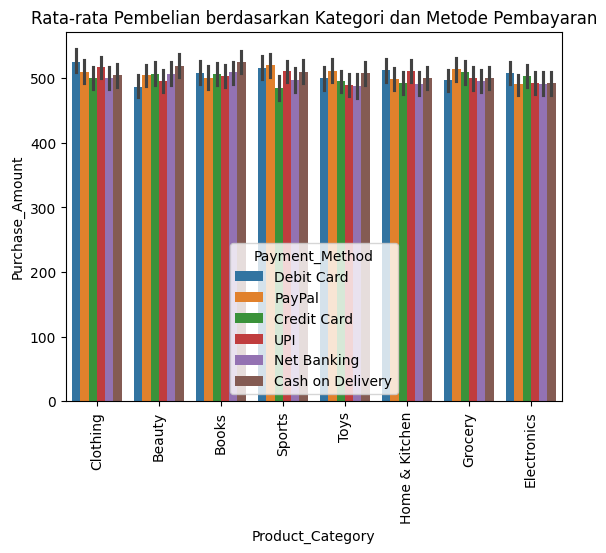

In [15]:
# Barplot rata-rata pembelian per kategori dan metode pembayaran
sns.barplot(x='Product_Category', y='Purchase_Amount', hue='Payment_Method', data=data)
plt.xticks(rotation=90)
plt.title('Rata-rata Pembelian berdasarkan Kategori dan Metode Pembayaran')
plt.show()


Plot tersebut memberikan gambaran distribusi pembelian berdasarkan kategori produk, banyaknya produk dan metode pembayaran yang di lakukan.

## Analisis Perilaku Pembelian

In [16]:
# Hitung jumlah pembelian per kategori produk
category_counts = data['Product_Category'].value_counts()
print(category_counts)


Product_Category
Toys              6392
Electronics       6320
Sports            6312
Books             6253
Clothing          6224
Grocery           6215
Home & Kitchen    6209
Beauty            6075
Name: count, dtype: int64


Kode tersebut menghitung jumlah pembelian untuk tiap kategori produk menggunakan `value_counts()`. Hasilnya menunjukkan bahwa kategori "Toys" paling sering dibeli, disusul oleh "Electronics" dan "Sports", sedangkan "Beauty" menjadi yang paling sedikit. Ini membantu memahami kategori produk yang paling diminati pelanggan.


In [17]:
# Total pembelian per kategori
category_sales = data.groupby('Product_Category')['Purchase_Amount'].sum().sort_values(ascending=False)
print(category_sales)


Product_Category
Sports            3195335.90
Toys              3185652.36
Books             3181897.30
Clothing          3171225.96
Electronics       3133965.04
Grocery           3123579.52
Home & Kitchen    3108945.78
Beauty            3057387.79
Name: Purchase_Amount, dtype: float64


Kode tersebut menghitung total nilai pembelian (`Purchase_Amount`) untuk setiap kategori produk dengan menggunakan fungsi `groupby()` dan `sum()`, lalu mengurutkannya dari yang tertinggi. Hasilnya menunjukkan bahwa kategori "Sports" memiliki total nilai pembelian tertinggi, diikuti oleh "Toys" dan "Books", sementara "Beauty" berada di urutan terakhir. Ini membantu mengidentifikasi kategori yang menghasilkan pendapatan terbesar.

In [18]:
data['Transaction_Date'] = pd.to_datetime(data['Transaction_Date'], errors='coerce')
data['Month'] = data['Transaction_Date'].dt.to_period('M')
monthly_sales = data.groupby('Month')['Purchase_Amount'].sum()
print(monthly_sales)


Month
2023-03     802390.44
2023-04    1046921.48
2023-05    1050553.40
2023-06    1011635.06
2023-07    1105402.88
2023-08    1044738.24
2023-09    1030080.62
2023-10    1046800.13
2023-11    1016654.63
2023-12    1071642.15
2024-01    1101023.49
2024-02    1004235.75
2024-03    1018957.55
2024-04    1047109.76
2024-05    1070447.76
2024-06    1032452.78
2024-07    1065266.58
2024-08    1061115.60
2024-09    1034725.55
2024-10    1079380.33
2024-11    1065021.09
2024-12    1061061.79
2025-01    1056467.57
2025-02     960776.35
2025-03     273128.67
Freq: M, Name: Purchase_Amount, dtype: float64


Kode tersebut mengonversi kolom `Transaction_Date` menjadi format tanggal, lalu membuat kolom `Month` untuk merepresentasikan bulan dan tahun dari setiap transaksi. Setelah itu, kode menghitung total pembelian (`Purchase_Amount`) per bulan menggunakan `groupby` dan `sum()`. Hasilnya menunjukkan tren bulanan total pembelian dari Maret 2023 hingga Maret 2025, yang bisa digunakan untuk analisis musiman atau tren penjualan dari waktu ke waktu.


In [19]:
payment_stats = data.groupby('Payment_Method')['Purchase_Amount'].agg(['count', 'mean', 'sum'])
print(payment_stats)


                  count        mean         sum
Payment_Method                                 
Cash on Delivery   8434  507.027434  4276269.38
Credit Card        8310  499.464158  4150547.15
Debit Card         8355  506.855321  4234776.21
Net Banking        8174  497.126426  4063511.41
PayPal             8250  505.882406  4173529.85
UPI                8477  502.460263  4259355.65


Kode ini menghitung jumlah transaksi, rata-rata, dan total pembelian untuk tiap metode pembayaran. Hasilnya menunjukkan bahwa UPI dan Cash on Delivery paling sering digunakan, dengan total pembelian tertinggi.

In [20]:
country_sales = data.groupby('Country')['Purchase_Amount'].sum().sort_values(ascending=False)
print(country_sales)


Country
France       2545739.19
Canada       2544335.12
USA          2541220.22
Mexico       2534475.67
Australia    2514911.65
Brazil       2507287.54
India        2503542.71
Germany      2502442.20
Japan        2492312.20
UK           2471723.15
Name: Purchase_Amount, dtype: float64


pada kode tersebut dapat dilihat negara mana yang menghasilkan pembelian tertinggi yaitunegara france

## segmentasi pelanggan

Kode ini melakukan segmentasi pelanggan berdasarkan usia, frekuensi, nilai pembelian, dan metode pembayaran. Pertama, pelanggan dikelompokkan berdasarkan usia untuk melihat total pembelian per kelompok. Selanjutnya, analisis RFM menghitung seberapa sering dan berapa banyak pelanggan berbelanja, serta seberapa baru pembelian mereka. Produk favorit pelanggan dihitung berdasarkan kategori yang sering dibeli, dan segmentasi metode pembayaran menunjukkan preferensi pembayaran yang digunakan pelanggan. Semua ini membantu memahami perilaku pelanggan untuk strategi pemasaran yang lebih tepat.


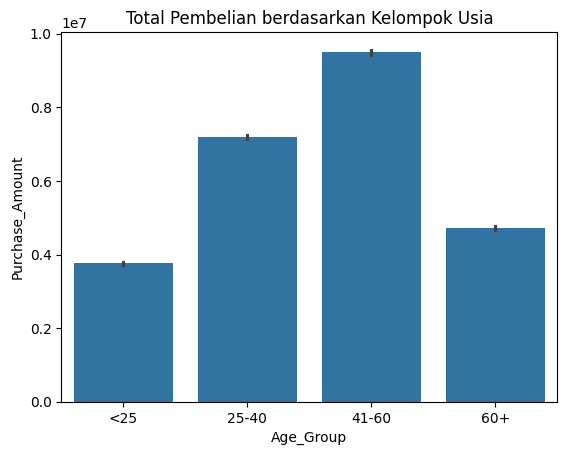

In [21]:
# Segmentasi usia: bisa gunakan binning
bins = [0, 25, 40, 60, 100]
labels = ['<25', '25-40', '41-60', '60+']
data['Age_Group'] = pd.cut(data['Age'], bins=bins, labels=labels)

# Contoh: Segmentasi pelanggan berdasarkan kelompok usia dan total pembelian
sns.barplot(x='Age_Group', y='Purchase_Amount', data=data, estimator=sum)
plt.title('Total Pembelian berdasarkan Kelompok Usia')
plt.show()


In [22]:
# Recency: hitung selisih hari dari tanggal terakhir
data['Transaction_Date'] = pd.to_datetime(data['Transaction_Date'], errors='coerce')
snapshot_date = data['Transaction_Date'].max() + pd.Timedelta(days=1)

rfm = data.groupby('User_Name').agg({
    'Transaction_Date': lambda x: (snapshot_date - x.max()).days,
    'Transaction_ID': 'count',
    'Purchase_Amount': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
print(rfm.head())


              Recency  Frequency   Monetary
User_Name                                  
Ava Allen           1        494  247865.13
Ava Anderson        1        491  246801.09
Ava Clark           2        517  273776.79
Ava Hall            6        517  268756.73
Ava Harris          4        520  266846.08


In [23]:
# Produk favorit setiap pelanggan
fav_products = data.groupby(['User_Name', 'Product_Category']).size().reset_index(name='Counts')
top_products = fav_products.sort_values(['User_Name', 'Counts'], ascending=[True, False]).drop_duplicates('User_Name')
print(top_products.head())


       User_Name Product_Category  Counts
4      Ava Allen          Grocery      78
8   Ava Anderson           Beauty      70
18     Ava Clark         Clothing      72
28      Ava Hall          Grocery      75
33    Ava Harris            Books      77


In [24]:
payment_segment = data.groupby(['User_Name', 'Payment_Method']).size().unstack(fill_value=0)
print(payment_segment.head())


Payment_Method  Cash on Delivery  Credit Card  Debit Card  Net Banking  \
User_Name                                                                
Ava Allen                     79           78          95           86   
Ava Anderson                  85           76          76           91   
Ava Clark                    102           87          81           77   
Ava Hall                      83           79          80           98   
Ava Harris                    75           71          84           93   

Payment_Method  PayPal  UPI  
User_Name                    
Ava Allen           83   73  
Ava Anderson        91   72  
Ava Clark           88   82  
Ava Hall            86   91  
Ava Harris          96  101  


# **prepossesing**
Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning. Data mentah sering kali mengandung duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang dilakukan
- membersihkan data yang hilang dan menghapus duplikat data
- menggunakan On Hot Enkoding untuk kolom kategori
- melakukan normalisasi dan stansarisasi
- menangani outlier data
- membagi data untuk data training dan data testing

In [25]:
# Menghapus baris yang memiliki nilai hilang
data.dropna(inplace=True)

In [26]:
# Menghapus duplikasi berdasarkan kolom tertentu atau seluruh baris
data.drop_duplicates(inplace=True)


In [27]:
# One-Hot Encoding untuk kolom kategori
data = pd.get_dummies(data, columns=['Product_Category', 'Country', 'Payment_Method'])


In [28]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data['Purchase_Amount'] = scaler.fit_transform(data[['Purchase_Amount']])


In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data['Age'] = scaler.fit_transform(data[['Age']])


In [30]:
Q1 = data['Purchase_Amount'].quantile(0.25)
Q3 = data['Purchase_Amount'].quantile(0.75)
IQR = Q3 - Q1

data = data[(data['Purchase_Amount'] >= (Q1 - 1.5 * IQR)) & (data['Purchase_Amount'] <= (Q3 + 1.5 * IQR))]


## **Modelling**


## Colaborative Filtering
Model rekomendasi yang telah dibuat menggunakan pendekatan Collaborative Filtering, tepatnya User-Based Collaborative Filtering dengan algoritma K-Nearest Neighbors (KNN). Model ini bekerja dengan mencari pengguna yang memiliki karakteristik dan riwayat pembelian yang mirip, lalu merekomendasikan produk berdasarkan preferensi pengguna-pengguna serupa tersebut.

In [31]:
# === Model Rekomendasi Berdasarkan Kategori Produk ===
product_columns = [col for col in data.columns if 'Product_Category_' in col]
country_columns = [col for col in data.columns if 'Country_' in col]

features_produk = ['Age'] + country_columns + product_columns
scaler_produk = StandardScaler()
X = scaler_produk.fit_transform(data[features_produk])

model_produk = NearestNeighbors(n_neighbors=6, algorithm='auto', metric='euclidean')
model_produk.fit(X)

def rekomendasi_produk(user_index):
    distances, indices = model_produk.kneighbors([X[user_index]])
    similar_users = data.iloc[indices[0][1:]]
    recommended_products = similar_users[product_columns].sum().sort_values(ascending=False).head(5)
    return recommended_products.index.tolist()

def tampilkan_semua_rekomendasi(user_index):
    print("===== Rekomendasi Berdasarkan Kategori Produk =====")
    rekomendasi = rekomendasi_produk(user_index)
    for i, produk in enumerate(rekomendasi, 1):
        print(f"{i}. {produk}")

# Panggil
tampilkan_semua_rekomendasi(100)


===== Rekomendasi Berdasarkan Kategori Produk =====
1. Product_Category_Sports
2. Product_Category_Beauty
3. Product_Category_Clothing
4. Product_Category_Books
5. Product_Category_Electronics


## **Evaluasi**

In [32]:
from sklearn.metrics import precision_score, recall_score
import math

def evaluasi_rekomendasi_produk(user_index, rekomendasi_fungsi, top_k=5):
    # Ambil produk yang direkomendasikan
    recommended = rekomendasi_fungsi(user_index)[:top_k]

    # Ambil data historis aktual user tersebut
    user_actual_data = data.iloc[user_index][product_columns]
    actual = user_actual_data[user_actual_data > 0].index.tolist()  # Produk yang benar-benar dibeli

    # Konversi ke format biner untuk evaluasi
    y_true = [1 if prod in actual else 0 for prod in recommended]
    y_pred = [1] * len(recommended)  # Semua hasil direkomendasikan (diasumsikan 1)

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    # Evaluasi Hit Rate
    hit_rate = 1 if any([prod in actual for prod in recommended]) else 0

    # Evaluasi Mean Average Precision (MAP)
    average_precision = 0
    for i, prod in enumerate(recommended):
        if prod in actual:
            average_precision += 1 / (i + 1)
    map_score = average_precision / top_k if average_precision > 0 else 0

    # Evaluasi NDCG
    dcg = 0
    for i, prod in enumerate(recommended):
        if prod in actual:
            dcg += 1 / (math.log(i + 2, 2))  # +2 untuk menghindari log(0)
    idcg = sum([1 / (math.log(i + 2, 2)) for i in range(top_k)])  # Ideal DCG
    ndcg = dcg / idcg if idcg > 0 else 0

    # Tampilkan hasil evaluasi
    print(f"Evaluasi untuk User {data.iloc[user_index]['User_Name']}:")
    print(f"Precision@{top_k}: {precision:.2f}")
    print(f"Recall@{top_k}: {recall:.2f}")
    print(f"Hit Rate@{top_k}: {hit_rate}")
    print(f"MAP@{top_k}: {map_score:.4f}")
    print(f"NDCG@{top_k}: {ndcg:.4f}")

# Panggil evaluasi untuk User ke-100
evaluasi_rekomendasi_produk(100, rekomendasi_produk)


Evaluasi untuk User Elijah Thompson:
Precision@5: 0.20
Recall@5: 1.00
Hit Rate@5: 1
MAP@5: 0.2000
NDCG@5: 0.3392


Hasil evaluasi sistem rekomendasi menunjukkan bahwa meskipun sistem berhasil menemukan produk yang relevan, masih ada ruang untuk perbaikan. Precision@5 yang rendah (0.20) menunjukkan bahwa hanya sedikit dari produk yang direkomendasikan yang relevan, meskipun Recall@5 sangat tinggi (1.00), yang berarti sistem berhasil menemukan semua produk relevan yang dibeli oleh pengguna dalam 5 produk teratas. Selain itu, NDCG@5 yang masih rendah (0.3392) menunjukkan bahwa meskipun ada produk relevan, posisi mereka dalam daftar rekomendasi tidak optimal. Meskipun sistem memberikan produk relevan dalam 5 teratas (Hit Rate@5 = 1), kualitas urutan dan presisi rekomendasi perlu diperbaiki untuk meningkatkan relevansi di posisi teratas.

Hasil evaluasi untuk User Elijah Thompson menunjukkan bahwa sistem rekomendasi memiliki kinerja yang cukup baik dalam hal cakupan, tetapi masih perlu ditingkatkan dari segi ketepatan posisi item relevan. Nilai **Precision\@5 sebesar 0,20** mengindikasikan bahwa hanya 1 dari 5 item yang direkomendasikan benar-benar relevan bagi pengguna. Meskipun demikian, nilai **Recall\@5 yang mencapai 1,00** menunjukkan bahwa semua item yang relevan berhasil dimasukkan dalam daftar 5 rekomendasi teratas, yang berarti tidak ada item relevan yang terlewatkan. Hal ini juga didukung oleh nilai **Hit Rate\@5 sebesar 1**, yang menandakan bahwa setidaknya ada satu item relevan yang berhasil direkomendasikan.

Namun, kualitas urutan rekomendasi masih dapat ditingkatkan. Nilai **MAP\@5 sebesar 0,2000** menunjukkan bahwa rata-rata posisi item relevan dalam daftar rekomendasi belum cukup tinggi, dan item relevan kemungkinan besar tidak muncul di posisi awal. Hal ini juga tercermin dalam nilai **NDCG\@5 sebesar 0,3392**, yang mengukur seberapa baik sistem menempatkan item relevan di posisi atas. Nilai ini tergolong rendah, sehingga dapat disimpulkan bahwa meskipun sistem mampu mencakup semua item relevan, ia belum optimal dalam menempatkannya pada posisi yang paling strategis. Secara keseluruhan, sistem sudah mampu mengenali preferensi user secara menyeluruh, tetapi perlu peningkatan dalam menyusun urutan rekomendasi agar lebih efektif.


In [33]:
%%writefile Laporan.txt
Laporan Proyek Machine Learning - [Titi Prihartati]

Judul : Pembangunan Sistem Rekomendasi untuk Memprediksi Preferensi Pembelian Pelanggan menggunakan Colaborative Filtering pada Dataset Walmart Customer Purchase Behavior

Project Overview
Proyek ini bertujuan untuk membangun sistem rekomendasi pembelian pelanggan Walmart menggunakan pendekatan Collaborative Filtering, khususnya User-Based Collaborative Filtering.
Sistem ini mengandalkan profil pelanggan (seperti usia dan negara), metode pembayaran, preferensi historis, dan kategori produk yang dibeli untuk menemukan pelanggan lain yang memiliki
pola belanja serupa. Dengan mencocokkan karakteristik pelanggan terhadap pengguna yang mirip, sistem ini dapat memberikan rekomendasi produk yang dipersonalisasi. Sistem ini penting karena
dalam e-commerce berskala besar seperti Walmart, kemampuan memberikan rekomendasi yang relevan dapat meningkatkan penjualan dan pengalaman pengguna. Selain itu, pendekatan ini tidak bergantung
pada rating eksplisit, sehingga cocok untuk diterapkan pada data transaksi riil. Menurut Lops et al. (2011), sistem rekomendasi berbasis perilaku pengguna juga efektif dalam menghasilkan saran yang
relevan ketika interaksi eksplisit terbatas.

Referensi :
Lops, P., De Gemmis, M., & Semeraro, G. (2011). Content-based recommender systems: State of the art and trends. Recommender systems handbook, 73-105.
Wijaya, A. E., & Alfian, D. (2018). Sistem Rekomendasi Laptop Menggunakan Collaborative Filtering Dan Content-Based Filtering. Jurnal Computech & Bisnis, 12(1), 11-27.

Business Understanding :
Problem Statement :
- Bagaimana membangun sistem rekomendasi produk menggunakan pendekatan Collaborative Filtering berdasarkan data transaksi pelanggan?
- Sejauh mana sistem rekomendasi yang dibangun efektif dalam memberikan saran produk yang relevan dan bermanfaat bagi pelanggan?
Goals:
- Mengembangkan sistem rekomendasi produk berbasis Collaborative Filtering dengan memanfaatkan atribut pelanggan dan histori interaksi pembelian.
- Mengevaluasi efektivitas sistem rekomendasi menggunakan metrik yang sesuai seperti Precision@N, Recall@N, dan NDCG.
Solution Approach:
- Membangun profil pelanggan berdasarkan atribut seperti usia, negara, metode pembayaran, dan histori pembelian kategori produk.
- Menerapkan algoritma User-Based Collaborative Filtering untuk menemukan pelanggan dengan pola belanja serupa.
- Menggunakan metrik evaluasi seperti Precision@N, Recall@N, dan NDCG untuk mengukur relevansi dan kualitas rekomendasi.
- Menyediakan output berupa daftar Top-N produk yang direkomendasikan secara personal untuk setiap pelanggan.

Data Understanding
Dataset : Walmart Customer Purchase Behavior Dataset
Sumber : https://www.kaggle.com/datasets/smayanj/e-commerce-transactions-dataset
jumlah data : 50000 baris dan 8 kolom

Informasi data
Pada tahap ini, dilakukan eksplorasi awal terhadap dataset yang digunakan untuk membangun sistem rekomendasi.
Dataset yang digunakan sebanyak 50.000 data yang berisi informasi transaksi pelanggan dari Walmart,
dengan masing-masing baris merepresentasikan satu transaksi pembelian.
Data set ini terdiri dari beberapa fitur utama sebagai berikut
- Transaction_ID    : ID unik untuk setiap transaksi.
- User_Name	        : Nama pelanggan yang melakukan transaksi.
- Age	              : Usia pelanggan dalam satuan tahun.
- Country	          : Negara asal pelanggan.
- Product_Category	: Kategori produk yang dibeli, seperti Clothing, Electronics, Home, dll.
- Purchase_Amount	  : Jumlah uang yang dibelanjakan dalam satu transaksi (dalam satuan mata uang, misal USD).
- Payment_Method	  : Metode pembayaran yang digunakan, seperti Credit Card, PayPal, atau Debit.
- Transaction_Date	: Tanggal saat transaksi dilakukan.

Dalam Data understanding dilakukan beberapa tahapan Exploratory Data Analysis (EDA):
- memahami struktur data dengan melihat tipe data tiap kolom, meninjau jumlah entry dan keunikan tiap fitur.
- melihat apakah terdapat data kosong atau duplikat data pada data set. Hal ini untuk melihat apakah data yang di gunakan sudah bersih atau belum.
- melakukan Visualisasi Distribusi Data untuk melihat bagaimana persebaran data.
- melakukan analisis awal terhadap perilaku pembelian dengan mengidentifkasi pola pembelian.
- melakukan segmentasi pelanggan.

Setelah dilakukan proses exploratory data analysis (EDA), dapat disimpulkan bahwa kondisi data sangat baik. Dataset ini tidak mengandung missing values.
Selain itu, tidak ditemukan duplikat, artinya setiap transaksi benar-benar unik dan tidak ada pengulangan data yang dapat mengganggu analisis. Pemeriksaan
terhadap outlier, khususnya pada kolom Purchase_Amount, juga menunjukkan bahwa nilai-nilai ekstrem yang muncul masih dalam batas wajar, kemungkinan berasal
dari pembelian produk dengan harga tinggi, sehingga tetap dianggap valid.
Berdasarkan visualisasi data, kategori produk **Clothing**, **Toys**, dan **Electronics** memiliki jumlah transaksi terbanyak. Dari segi negara, transaksi
paling banyak terjadi di **Canada**, diikuti oleh **Mexico** dan **Germany**. Plot ini memberikan gambaran umum tentang distribusi pembelian berdasarkan
kategori produk, jumlah transaksi, dan metode pembayaran yang digunakan.

Data Preparation
Tahap ini bertujuan intuk membersihkan dan mempersiapkan data agar dapat digunakan secara optimal. dalam tahapan ini meliputi:
- penanganan missing value dan duplikat data. Dalam data terlihat data sudah bersih dan tidak terdapat duplikat data. hal ini untuk memastikan kualitas data sebelum digunakan dalam model machine learning.
- melakukan enkoding data kategorikal dengan menerapkan one hot Encoding yaitu pada data 'Product_Category', 'Country', 'Payment_Method'
- melakukan normalisasi fitur numerik data menggunakan min-max scaling.
- melakukan standarisasi pada data Age.
- mengkonversi tipe data sesuai dengan yang di butuhkan.
- Melakukan Penanganan Outlier pada data Purchase_Amount
Dengan data yang telah dipersiapkan secara sistematis, sistem rekomendasi dapat bekerja lebih akurat dan efisien

Modelling
Sistem rekomendasi yang telah dibuat menggunakan User-Based Collaborative Filtering dengan algoritma K-Nearest Neighbors (KNN).
Pendekatan ini memilih pengguna yang mirip dengan pengguna yang ingin diberikan rekomendasi, berdasarkan karakteristik seperti usia,
negara, dan kategori produk yang dibeli. Produk yang sering dibeli oleh pengguna-pengguna yang mirip ini kemudian direkomendasikan kepada pengguna tersebut.

Cara Kerja:
- Input Data: Data yang digunakan meliputi informasi pengguna (usia, negara) dan produk yang mereka beli (kategori produk).
Proses:
- One-Hot Encoding diterapkan pada kolom kategori produk dan negara.
- Normalisasi dilakukan untuk fitur numerik (misalnya, usia).
- KNN digunakan untuk menemukan pengguna yang mirip.
Output: Rekomendasi produk diberikan berdasarkan frekuensi pembelian produk oleh pengguna yang mirip.
Output dari sistem rekomendasi yang dihasilkan untuk user ke-100 (misalnya) adalah Top-5 produk yang sering dibeli oleh pengguna serupa:
===== Rekomendasi Berdasarkan Kategori Produk =====
1. Product_Category_Sports
2. Product_Category_Beauty
3. Product_Category_Clothing
4. Product_Category_Books
5. Product_Category_Electronics

Evaluasi:
Metrik evaluasi yang digunakan untuk mengukur kinerja sistem rekomendasi meliputi **Precision**, **Recall**, **Hit Rate**,
**MAP (Mean Average Precision)**, dan **NDCG (Normalized Discounted Cumulative Gain)**. **Precision** mengukur proporsi produk relevan dalam rekomendasi,
sementara **Recall** mengukur proporsi produk relevan yang berhasil direkomendasikan. **Hit Rate** mengevaluasi apakah ada produk relevan dalam rekomendasi,
sementara **MAP** menghitung rata-rata presisi pada berbagai peringkat dalam rekomendasi. **NDCG** mengukur kualitas urutan rekomendasi dengan mempertimbangkan posisi produk relevan.
Hasil evaluasi untuk User ke-100 menunjukkan bahwa **Precision\@5** adalah 0.20, yang berarti hanya 20% produk relevan yang muncul dalam rekomendasi. **Recall\@5** adalah 1.00, yang
menunjukkan bahwa semua produk relevan berhasil direkomendasikan, dan **Hit Rate\@5** adalah 1, yang mengindikasikan bahwa ada produk relevan dalam rekomendasi. **MAP\@5** adalah 0.20,
yang berarti rata-rata presisi pada rekomendasi adalah 0.20, sementara **NDCG\@5** adalah 0.34, yang menunjukkan bahwa posisi produk relevan dalam rekomendasi masih belum optimal.
Secara keseluruhan, meskipun sistem berhasil menemukan produk relevan (dengan Recall dan Hit Rate yang tinggi), **Precision** dan **NDCG** yang rendah menunjukkan bahwa masih banyak produk
yang tidak relevan direkomendasikan dan produk relevan sering muncul di urutan bawah, yang dapat menjadi area untuk perbaikan.

Proyek ini menggunakan metrik evaluasi seperti **Precision\@5**, **Recall\@5**, **Hit Rate**, **MAP**, dan **NDCG** untuk menilai kualitas rekomendasi. Metrik tersebut relevan karena mampu
mengukur ketepatan dan relevansi rekomendasi produk, sesuai dengan kebutuhan bisnis e-commerce. Hasil evaluasi menunjukkan **recall dan hit rate tinggi**, artinya sistem berhasil menyarankan
produk yang memang disukai pengguna. Namun, **precision dan NDCG** masih rendah, menunjukkan perlu peningkatan dalam ketepatan dan urutan produk. Secara umum, model sudah menjawab problem
statement dan mendukung tujuan bisnis dengan memberikan rekomendasi yang cukup relevan, meskipun masih ada ruang untuk penyempurnaan.



Writing Laporan.txt
